<a href="https://colab.research.google.com/github/Crypto2000Bytes/Pyomo-models/blob/main/pyomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyomo


     |████████████████████████████████| 9.1 MB 6.3 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 


In [3]:
!apt-get install -y -qq glpk-utils


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import numpy as np
import time


In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
dataGen = pd.read_excel('/content/drive/MyDrive/inputs.xlsx', sheet_name='gen')
dataLoad = pd.read_excel('/content/drive/MyDrive/inputs.xlsx', sheet_name='load')
Ng = len(dataGen)

In [75]:
model = pyo.ConcreteModel()

In [76]:
model.Pg = pyo.Var(range(0,Ng), bounds = (0,np.inf))
Pg = model.Pg

In [77]:
# Constraints
#balans

Pg_sum = sum(Pg[i] for i in dataGen.id )
Pd = dataLoad.value
Pd_sum = sum(Pd[i] for i in dataLoad.id)
model.balans = pyo.Constraint(expr = Pg_sum == Pd_sum)

In [78]:
# Pg[0]+ Pg[3] => Pd[0]

model.con1 = pyo.Constraint(expr = Pg[0]+Pg[3]==Pd[0])

In [79]:
#limits
model.limits = pyo.ConstraintList()
for i in dataGen.id:
  model.limits.add(Pg[i]<=dataGen.limit[i])


In [80]:
#Objective

model.obj = pyo.Objective(expr = sum(dataGen.cost[i] * Pg[i]for i in dataGen.id))

In [81]:
start_tijd = time.time()
opt = pyo.SolverFactory('glpk')
opt.solve(model)
eind_tijd = time.time()-start_tijd

2 Set Declarations
    Pg_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}
    limits_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}

1 Var Declarations
    Pg : Size=5, Index=Pg_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  20.0 :   inf : False : False :  Reals
          1 :     0 :  10.0 :   inf : False : False :  Reals
          2 :     0 :  35.0 :   inf : False : False :  Reals
          3 :     0 :  30.0 :   inf : False : False :  Reals
          4 :     0 :   5.0 :   inf : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : 0.1*Pg[0] + 0.05*Pg[1] + 0.3*Pg[2] + 0.4*Pg[3] + 0.01*Pg[4]

3 Constraint Declarations
    balans : Size

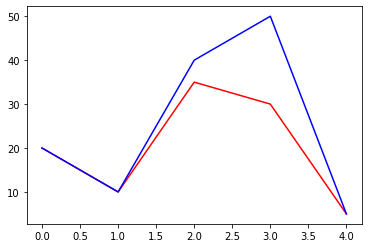

In [90]:
model.pprint()
print('\n**********************\n')
print(eind_tijd)
print('\n**********************\n')
dataGen['Pg'] = [pyo.value(Pg[i])for i in dataGen.id]
print(dataGen)

plt.plot([pyo.value(Pg[i])for i in dataGen.id],'r') #produced energy
plt.plot([dataGen.limit[i]for i in dataGen.id],'b') # limits
